# Testing on subset of Food101

The subset has been created by taking a random sample of 80 images from each category.

**Importing the libraries and loading the dataset**

In [1]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os
import openai
import configparser
import torch
import clip
from torch.utils.data import Subset
import sys
sys.path.append('../')
from Classifier import Classifier
config = configparser.ConfigParser()
config.read('../config.ini')

api_key = config['openai']['api_key']
openai.api_key = api_key

dataset = ImageFolder(root='./food')
labels=dataset.classes

Label: fish_and_chips


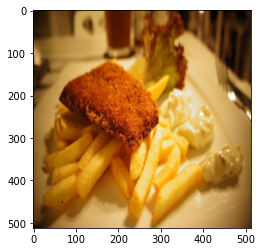

In [2]:
print(f"Label: {labels[dataset[3050][1]]}")
plt.imshow(dataset[3050][0])

**Creating a classifier and loading descriptors that were generated previously**

In [3]:
food=Classifier(labels)

In [4]:
food.load_classifier('food101.txt')

In [5]:
food.descriptors['fish_and_chips']

['has a crispy batter', 'has a light and fluffy texture', 'has a golden color']

**Classifying with the descriptors**

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
tokenized_text = torch.cat([clip.tokenize(label) for label in labels]).to(device)

In [7]:
from time import time
sum1=0
sum2=0
for i in range(0,len(dataset),100):
    if i==8000:
        subset=Subset(dataset,[j for j in range(i,len(dataset))])
        images=torch.stack([food.preprocess(image) for (image,label) in subset])
        lab=torch.Tensor([label for (image,label) in subset])
    else:
        subset=Subset(dataset,[j for j in range(i,i+100)])
        images=torch.stack([food.preprocess(image) for (image,label) in subset])
        lab=torch.Tensor([label for (image,label) in subset])
    print(f'Starting predictions: {i}')
    t=time()
    pred1=food.multi_classify(images,preprocessed=True)
    sum1+=torch.sum((pred1==lab)+0.)
    
    logits=model(images,tokenized_text)[0]
    pred2=torch.argmax(logits,dim=1)
    sum2+=torch.sum((pred2==lab)+0.)
    print(time()-t)
avg1=sum1/len(dataset)
avg2=sum2/len(dataset)

print(f'Accuracy of the custom algorithm: {avg1}')
print(f'Accuracy of the traditional zero shot prediction: {avg2}')

Starting predictions: 0
508.07701659202576
Starting predictions: 100
524.9845700263977
Starting predictions: 200
518.2847924232483
Starting predictions: 300
522.8167889118195
Starting predictions: 400
523.1080112457275
Starting predictions: 500
518.7708160877228
Starting predictions: 600
519.139466047287
Starting predictions: 700
510.9637243747711
Starting predictions: 800
523.0887858867645
Starting predictions: 900
504.56872296333313
Starting predictions: 1000
512.893678188324
Starting predictions: 1100
706.7455177307129
Starting predictions: 1200
519.8756651878357
Starting predictions: 1300
633.1192963123322
Starting predictions: 1400
536.8344202041626
Starting predictions: 1500
609.5310554504395
Starting predictions: 1600
663.5468256473541
Starting predictions: 1700
536.0511236190796
Starting predictions: 1800
664.0739991664886
Starting predictions: 1900
517.1139674186707
Starting predictions: 2000
780.0454845428467
Starting predictions: 2100
558.093008518219
Starting predictions: 2

In [8]:
with open("food101_results.txt", "w") as f:
    f.write(f'Accuracy of the custom algorithm: {avg1}')
    f.write(f'Accuracy of the traditional zero shot prediction: {avg2}')